In [1]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes, fetch_mldata
from  matplotlib.collections import LineCollection
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
from scipy.special import expit

from stratpd.plot import *
from stratpd.ice import *

def df_string_to_cat(df:pd.DataFrame) -> dict:
    catencoders = {}
    for colname in df.columns:
        if is_string_dtype(df[colname]) or is_object_dtype(df[colname]):
            df[colname] = df[colname].astype('category').cat.as_ordered()
            catencoders[colname] = df[colname].cat.categories
    return catencoders

def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

In [2]:
df = pd.DataFrame()
a,b = -5,5
n = 20
df['x1'] = np.linspace(a,b,n-1)
df['y']  = np.where(df['x1'].values<0, 0, 1)
df

,x1,y
0,-5.000000,0
1,-4.444444,0
2,-3.888889,0
3,-3.333333,0
4,-2.777778,0
5,-2.222222,0
6,-1.666667,0
7,-1.111111,0
8,-0.555556,0
9,0.000000,1


In [3]:
X, y = df[['x1']], df['y']
lr = LinearRegression()
lr.fit(X, y)
logr = LogisticRegression()
logr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

odds [1.00339841e-03 2.21467853e-03 4.88818891e-03 1.07891012e-02
 2.38134628e-02 5.25605425e-02 1.16010454e-01 2.56055678e-01
 5.65160364e-01 1.24740931e+00 2.75325393e+00 6.07692049e+00
 1.34128430e+01 2.96045269e+01 6.53424496e+01 1.44222393e+02
 3.18324439e+02 7.02598582e+02 1.55075987e+03]
p [0.00100239 0.00220978 0.00486441 0.01067394 0.02325957 0.04993589
 0.10395105 0.20385695 0.36108783 0.55504323 0.73356452 0.8586956
 0.93061744 0.9673251  0.98492669 0.99311401 0.99686839 0.99857874
 0.99935557]


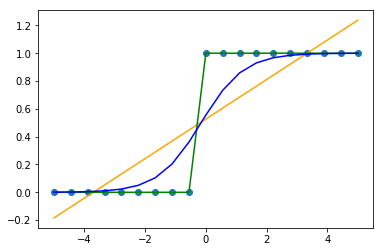

In [4]:
fig, ax = plt.subplots(1, 1)

def sigmoid(x): return 1 / (1 + np.exp(-x))

ax.scatter(X.values, y)
ax.plot(X.values, lr.predict(X), c='orange')
ax.plot(X.values, logr.predict(X), c='green')
y_ = logr.predict(X.values)
y_ = X.values * logr.coef_[0] + logr.intercept_
#print(y_)
odds = np.exp(y_).ravel()
print(f"odds {odds}")
p = odds / (1 + odds)
print(f"p {p}")
ax.plot(X.values, sigmoid(y_), c='blue')
#ax.plot(X.values, (expit(lr.predict(X))), c='maroon')

#ax.legend()
plt.show()

In [5]:
lr.coef_[0], logr.coef_[0]

(0.14210526315789468, array([1.4250863]))

In [6]:
lr.intercept_, logr.intercept_

(0.5263157894736842, array([0.22106885]))

In [7]:
lr2 = LinearRegression()
lr2.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

# scikit-learn's one-vs-rest OVR

In [8]:
df = pd.DataFrame()
a,b = 0,10
n = 20
df['x1'] = np.linspace(a,b,n)
#df['x2'] = np.random.uniform(a,b,size=n)
df['y']  = np.where(df['x1'].values<7, np.where(df['x1'].values<3, 1, 2), 3)
# df['y']  = np.where(df['x1'].values<0, 2, 3)
df

,x1,y
0,0.000000,1
1,0.526316,1
2,1.052632,1
3,1.578947,1
4,2.105263,1
5,2.631579,1
6,3.157895,2
7,3.684211,2
8,4.210526,2
9,4.736842,2


In [9]:
X, y = df[['x1']], df['y']
logr = LogisticRegression(multi_class='ovr', C=10) # no regularization
logr.fit(X, y)
print(logr.classes_)
print(logr.intercept_)
print(logr.coef_.flatten())

[1 2 3]
[ 4.10541967 -0.37643867 -5.61840483]
[-1.53660929 -0.00424127  0.81657241]


[[7.05531357e-01 2.91874461e-01 2.59418205e-03]
 [7.00651795e-01 2.95316640e-01 4.03156501e-03]
 [6.90206657e-01 3.03437292e-01 6.35605090e-03]
 [6.68262951e-01 3.21422696e-01 1.03143523e-02]
 [6.24013509e-01 3.58409371e-01 1.75771196e-02]
 [5.42601892e-01 4.25614314e-01 3.17837945e-02]
 [4.17010717e-01 5.23756516e-01 5.92327675e-02]
 [2.69754302e-01 6.24205934e-01 1.06039764e-01]
 [1.45589740e-01 6.82347002e-01 1.72063258e-01]
 [6.80721675e-02 6.81230095e-01 2.50697737e-01]
 [2.90298001e-02 6.36843165e-01 3.34127035e-01]
 [1.17643804e-02 5.72766237e-01 4.15469383e-01]
 [4.66041757e-03 5.06402343e-01 4.88937239e-01]
 [1.84069328e-03 4.47521846e-01 5.50637461e-01]
 [7.34580678e-04 4.00060818e-01 5.99204602e-01]
 [2.98421695e-04 3.64241845e-01 6.35459734e-01]
 [1.23687666e-04 3.38420151e-01 6.61456161e-01]
 [5.22295666e-05 3.20375841e-01 6.79571930e-01]
 [2.23974112e-05 3.08016232e-01 6.91961370e-01]
 [9.71836738e-06 2.99646828e-01 7.00343453e-01]]


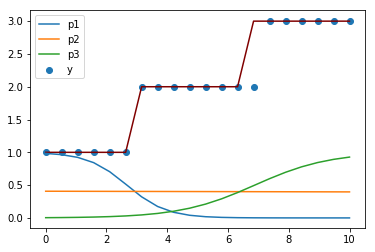

In [10]:
fig, ax = plt.subplots(1, 1)

def sigmoid(x): return 1 / (1 + np.exp(-x))
def logodds2prob(x): return 1 / (1 + np.exp(x))

ax.scatter(X.values, y)
ax.plot(X.values, logr.predict(X), c='maroon')
print(logr.predict_proba(X))
y_ = logr.predict(X.values)
coef = logr.coef_.flatten()
y1 = X.values * coef[0] + logr.intercept_[0]
y2 = X.values * coef[1] + logr.intercept_[1]
y3 = X.values * coef[2] + logr.intercept_[2]
p1 = 1-logodds2prob(y1) # sklearn is treating the y values in weird way; needed to flip probabilities
p2 = 1-logodds2prob(y2)
p3 = 1-logodds2prob(y3)
ax.plot(X.values, p1, label='p1')
ax.plot(X.values, p2, label='p2')
ax.plot(X.values, p3, label='p3')

#print(y_)
odds = np.exp(y_).ravel()
#print(f"odds {odds}")
p = odds / (1 + odds)
#print(f"p {p}")
#ax.plot(X.values, sigmoid(y_), c='blue')
#ax.plot(X.values, (expit(lr.predict(X))), c='maroon')

ax.legend()
plt.show()

# Try doing one-vs-rest using binary log regr

In [14]:
df = pd.DataFrame()
a,b = 0,10
n = 20
df['x1'] = np.linspace(a,b,n)
df['y']  = np.where(df['x1'].values<7, np.where(df['x1'].values<3, 1, 2), 3)
df

,x1,y
0,0.000000,1
1,0.526316,1
2,1.052632,1
3,1.578947,1
4,2.105263,1
5,2.631579,1
6,3.157895,2
7,3.684211,2
8,4.210526,2
9,4.736842,2


In [15]:
X, y = df[['x1']], df['y']
classes = np.unique(y)

intercepts = []
coefs = []
for c in classes:
    logr = LogisticRegression(multi_class='ovr', C=10) # no regularization
    y_ = np.where(y!=c, 1, 0)
    logr.fit(X, y_)
    coef = logr.coef_.flatten()
    coefs.append(coef[0])
    intercepts.append(logr.intercept_)

    print(f"Class {c}", 'intercept', logr.intercept_, 'beta', logr.coef_.flatten())
    print(logr.predict_proba(X)[:,0])
    
coefs = np.array(coefs)
intercepts = np.array(intercepts)

Class 1 intercept [-4.10541967] beta [1.53660929]
[9.83784187e-01 9.64314669e-01 9.23291764e-01 8.42797837e-01
 7.04839895e-01 5.15422858e-01 3.21468635e-01 1.74254109e-01
 8.59190003e-02 4.01846467e-02 1.83069546e-02 8.23788701e-03
 3.68614500e-03 1.64523927e-03 7.33488712e-04 3.26842151e-04
 1.45607825e-04 6.48616086e-05 2.88915782e-05 1.28690400e-05]
Class 2 intercept [0.37643867] beta [0.00424127]
[0.40698613 0.4064475  0.40590908 0.4053709  0.40483294 0.40429521
 0.40375771 0.40322044 0.4026834  0.4021466  0.40161003 0.4010737
 0.4005376  0.40000174 0.39946612 0.39893074 0.3983956  0.39786071
 0.39732606 0.39679165]
Class 3 intercept [5.61840483] beta [-0.81657241]
[0.0036173  0.00554869 0.00850251 0.01300822 0.01985383 0.03019174
 0.04566184 0.06849887 0.1015422  0.14799294 0.21070929 0.29092818
 0.38672362 0.49216802 0.59831387 0.69597831 0.77868066 0.84393058
 0.89259673 0.92739321]


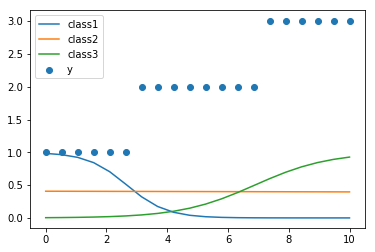

In [16]:
fig, ax = plt.subplots(1, 1)

def sigmoid(x): return 1 / (1 + np.exp(-x))
def logodds2prob(x): return 1 / (1 + np.exp(x))

ax.scatter(X.values, y)
for ci,c in enumerate(classes):
    logodds = X.values * coefs[ci] + intercepts[ci]
    p = logodds2prob(logodds)
    ax.plot(X.values, p, label=f'class{c}')

ax.legend()
plt.show()

ok, same results but before it seemed to flip 1 vs {2,3} etc... so same after 1-p. it looks like sklearn in multinomial mode is ensuring the probabilities from predict_probab all sum to 1 for any x

To go from binary case which gives one coeff, negate beta and intercept to get other.